In [ ]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00


**Simulation code and plotting the potential energy function**

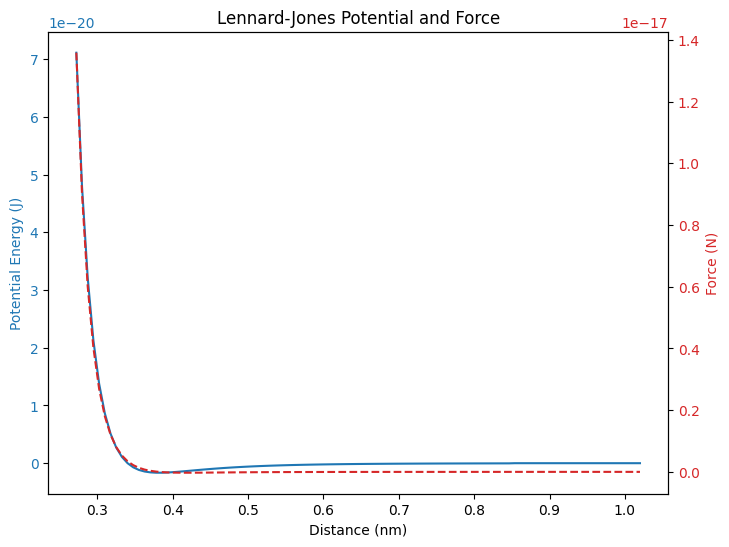

Initial Distance: 0.4703 nm
Initial Force on Atom 1: [-1.71273581e-20  4.91235685e-21  4.29834121e-21]
Initial Force on Atom 2: [ 1.71273581e-20 -4.91235685e-21 -4.29834121e-21]
Initial Velocity of Atom 1: [ 2524.88436407 -1173.03375238  1355.64636301]
Initial Velocity of Atom 2: [-1157.90043377 -1163.67737366   604.56953532]
Step 0: Distance = 0.4703 nm
Force on Atom 1: [-1.71273581e-20  4.91235685e-21  4.29834121e-21]
Velocity of Atom 1: [ 2524.88436406 -1173.03375238  1355.64636301]

Step 1000: Distance = 0.4703 nm
Force on Atom 1: [-1.71273549e-20  4.91235573e-21  4.29834008e-21]
Velocity of Atom 1: [ 2524.88436277 -1173.03375201  1355.64636334]

Step 2000: Distance = 0.4703 nm
Force on Atom 1: [-1.71273517e-20  4.91235460e-21  4.29833895e-21]
Velocity of Atom 1: [ 2524.88436148 -1173.03375164  1355.64636366]

Step 3000: Distance = 0.4703 nm
Force on Atom 1: [-1.71273485e-20  4.91235348e-21  4.29833782e-21]
Velocity of Atom 1: [ 2524.88436019 -1173.03375127  1355.64636399]

Step 40

interactive(children=(IntSlider(value=100, description='max_timestep', max=10000, min=10, step=10), Output()),…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact, IntSlider

# Constants
sigma = 0.34  # nm
epsilon = 120 * 1.38e-23  # J
mass = 39.948 * 1.66e-27  # kg
kb = 1.38e-23  # J/K
dt = 5e-15  # s
num_steps = 10000  # Reduced for debugging
cutoff = 2.5 * sigma
box_size = 3.0  # nm

# Initialize Positions ensuring interaction
np.random.seed(42)
position1 = np.random.uniform(0.5, box_size - 0.5, (3,))

# Generate random unit vector for Atom 2 placement
random_direction = np.random.normal(0, 1, (3,))
random_direction /= np.linalg.norm(random_direction)
distance = np.random.uniform(1.1 * sigma, 1.5 * sigma)  # Ensures strong force
position2 = position1 + random_direction * distance
position2 = position2 % box_size  # Apply PBCs

# Initial velocities (Increased for more noticeable movement)
temperature = 300  # K
std_dev = np.sqrt(kb * temperature / mass)
velocity1 = np.random.normal(0, std_dev, (3,)) * 10
velocity2 = np.random.normal(0, std_dev, (3,)) * 10

# Store trajectories
positions1_list = [position1.copy()]
positions2_list = [position2.copy()]
velocities1_list = [velocity1.copy()]
velocities2_list = [velocity2.copy()]

# Lennard-Jones Potential Function
def lennard_jones_potential(r):
    if r > cutoff:
        return 0
    return 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

# Lennard-Jones Force Function
def lennard_jones_force(r1, r2, box_size):
    delta_r, r = r1 - r2, np.linalg.norm(r1 - r2)
    delta_r -= box_size * np.round(delta_r / box_size)  # Apply PBC
    if r > cutoff:
        return np.zeros(3), np.zeros(3)

    force_mag = 24 * epsilon * (2 * (sigma / r) ** 12 - (sigma / r) ** 6) / r ** 2
    force = force_mag * delta_r / r
    return force, -force

# Debugging Plot: Lennard-Jones Potential & Force
r_values = np.linspace(0.8 * sigma, 3 * sigma, 100)
lj_potential_values = [lennard_jones_potential(r) for r in r_values]
lj_force_values = [lennard_jones_force(np.array([r, 0, 0]), np.array([0, 0, 0]), 10)[0][0] for r in r_values]

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.set_xlabel("Distance (nm)")
ax1.set_ylabel("Potential Energy (J)", color="tab:blue")
ax1.plot(r_values, lj_potential_values, color="tab:blue", label="LJ Potential")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Force (N)", color="tab:red")
ax2.plot(r_values, lj_force_values, color="tab:red", linestyle="dashed", label="LJ Force")
ax2.tick_params(axis="y", labelcolor="tab:red")
plt.title("Lennard-Jones Potential and Force")
plt.show()

# Print Initial Conditions
force1, force2 = lennard_jones_force(position1, position2, box_size)
print(f"Initial Distance: {np.linalg.norm(position1 - position2):.4f} nm")
print(f"Initial Force on Atom 1: {force1}")
print(f"Initial Force on Atom 2: {force2}")
print(f"Initial Velocity of Atom 1: {velocity1}")
print(f"Initial Velocity of Atom 2: {velocity2}")

# Run MD Simulation
for step in range(num_steps):
    force1, force2 = lennard_jones_force(position1, position2, box_size)

    new_position1 = position1 + velocity1 * dt + 0.5 * (force1 / mass) * dt ** 2
    new_position2 = position2 + velocity2 * dt + 0.5 * (force2 / mass) * dt ** 2

    new_position1 = new_position1 % box_size
    new_position2 = new_position2 % box_size

    new_force1, new_force2 = lennard_jones_force(new_position1, new_position2, box_size)

    velocity1 += 0.5 * (force1 + new_force1) / mass * dt
    velocity2 += 0.5 * (force2 + new_force2) / mass * dt

    positions1_list.append(new_position1.copy())
    positions2_list.append(new_position2.copy())
    velocities1_list.append(velocity1.copy())
    velocities2_list.append(velocity2.copy())

    position1 = new_position1
    position2 = new_position2

    # Debugging: Print forces and distances at regular intervals
    if step % 1000 == 0:
        print(f"Step {step}: Distance = {np.linalg.norm(position1 - position2):.4f} nm")
        print(f"Force on Atom 1: {force1}")
        print(f"Velocity of Atom 1: {velocity1}\n")

positions1_array = np.array(positions1_list)
positions2_array = np.array(positions2_list)
velocities1_array = np.array(velocities1_list)
velocities2_array = np.array(velocities2_list)

# Function to plot trajectory
def plot_trajectory(max_timestep):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})

    ax.plot(positions1_array[:max_timestep, 0], positions1_array[:max_timestep, 1], positions1_array[:max_timestep, 2],
            marker='o', linestyle='-', color='blue', label="Atom 1")
    ax.plot(positions2_array[:max_timestep, 0], positions2_array[:max_timestep, 1], positions2_array[:max_timestep, 2],
            marker='o', linestyle='-', color='red', label="Atom 2")

    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_zlim(0, box_size)
    ax.set_xlabel("X Position (nm)")
    ax.set_ylabel("Y Position (nm)")
    ax.set_zlabel("Z Position (nm)")
    ax.set_title(f"Trajectory of Two Argon Atoms (0 to {max_timestep})")
    ax.legend()
    plt.show()

    print(f"\nTimestep: {max_timestep}")
    print(f"Position of Atom 1: {positions1_array[max_timestep]}")
    print(f"Velocity of Atom 1: {velocities1_array[max_timestep]}")
    print(f"Position of Atom 2: {positions2_array[max_timestep]}")
    print(f"Velocity of Atom 2: {velocities2_array[max_timestep]}\n")

interact(plot_trajectory, max_timestep=IntSlider(min=10, max=num_steps, step=10, value=100));

**Plotting the force, velocity, position of atoms**

In [ ]:
import numpy as np

# Constants
sigma = 0.34  # nm
epsilon = 120 * 1.38e-23  # J
mass = 39.948 * 1.66e-27  # kg
kb = 1.38e-23  # J/K

dt = 1e-15  # s
cutoff = 2.5 * sigma
J_to_eV = 6.242e18  # Convert Joules to eV

# Convert velocity from m/s to nm/dt
def convert_velocity_to_nm_per_timestep(v_m_s):
    return v_m_s * 1e9 * dt

# Convert force to acceleration (m/s²) and displacement (nm/dt²)
def convert_force_to_nm_per_dt2(F, mass):
    a_m_s2 = F / mass  # Compute acceleration (m/s²)
    return a_m_s2 * 1e9 * dt**2  # Convert to nm/dt²

# Lennard-Jones Potential Function (in eV)
def lennard_jones_potential(r):
    if r > cutoff:
        return 0
    return 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6) * J_to_eV  # Convert J to eV

# Lennard-Jones Force Function
def lennard_jones_force(r1, r2, box_size):
    delta_r = r1 - r2
    delta_r -= box_size * np.round(delta_r / box_size)  # Apply PBC
    r = np.linalg.norm(delta_r)

    if r > cutoff:
        return np.zeros(3), np.zeros(3), 0  # Zero force and potential if outside cutoff

    force_mag = 24 * epsilon * (2 * (sigma / delta_r) ** 12 - (sigma / delta_r) ** 6) / r
    force = force_mag * delta_r / r
    potential = lennard_jones_potential(r)  # Compute potential in eV

    return force, -force, potential

# Initialize Positions
np.random.seed(42)
position1 = np.random.uniform(0.5, 2.5, (3,))
random_direction = np.random.normal(0, 1, (3,))
random_direction /= np.linalg.norm(random_direction)
distance = np.random.uniform(1.1 * sigma, 1.5 * sigma)  # Ensures strong force
position2 = position1 + random_direction * distance

# Initial Velocities (Converted to nm/dt)
temperature = 300  # K
std_dev = np.sqrt(kb * temperature / mass)
velocity1 = convert_velocity_to_nm_per_timestep(np.random.normal(0, std_dev, (3,)) * 10)
velocity2 = convert_velocity_to_nm_per_timestep(np.random.normal(0, std_dev, (3,)) * 10)

# Print Initial Conditions
force1, force2, potential = lennard_jones_force(position1, position2, box_size)
print("\nInitial Conditions:")
print(f"Distance: {np.linalg.norm(position1 - position2):.4f} nm")
print(f"Potential Energy: {potential:.4f} eV")
print(f"Force on Atom 1: {force1} N")
print(f"Force on Atom 2: {force2} N")
print(f"Acceleration on Atom 1: {convert_force_to_nm_per_dt2(force1, mass)} nm/dt²")
print(f"Acceleration on Atom 2: {convert_force_to_nm_per_dt2(force2, mass)} nm/dt²")
print(f"Velocity of Atom 1: {velocity1} nm/dt")
print(f"Velocity of Atom 2: {velocity2} nm/dt")
print(f"Initial Position of Atom 1: {position1} nm")
print(f"Initial Position of Atom 2: {position2} nm\n")

# Run 10 Steps of MD Simulation (for debugging)
num_steps = 10
for step in range(num_steps):
    force1, force2, potential = lennard_jones_force(position1, position2, box_size)

    # Update Position (Velocity Verlet)
    new_position1 = position1 + velocity1 * dt
    new_position2 = position2 + velocity2 * dt

    # Apply Periodic Boundary Conditions
    new_position1 = new_position1 % box_size
    new_position2 = new_position2 % box_size

    # Compute New Forces
    new_force1, new_force2, new_potential = lennard_jones_force(new_position1, new_position2, box_size)

    # Update Velocity
    new_velocity1 = velocity1 + 0.5 * (force1 + new_force1) / mass * dt
    new_velocity2 = velocity2 + 0.5 * (force2 + new_force2) / mass * dt

    # Convert Velocity to nm/dt
    new_velocity1 = convert_velocity_to_nm_per_timestep(new_velocity1)
    new_velocity2 = convert_velocity_to_nm_per_timestep(new_velocity2)

    # Print Step Information
    print(f"Step {step + 1}:")
    print(f"Distance: {np.linalg.norm(new_position1 - new_position2):.4f} nm")
    print(f"Potential Energy: {new_potential:.4f} eV")
    print(f"Force on Atom 1: {new_force1} N")
    print(f"Force on Atom 2: {new_force2} N")
    print(f"Acceleration on Atom 1: {convert_force_to_nm_per_dt2(new_force1, mass)} nm/dt²")
    print(f"Acceleration on Atom 2: {convert_force_to_nm_per_dt2(new_force2, mass)} nm/dt²")
    print(f"Velocity of Atom 1: {new_velocity1} nm/dt")
    print(f"Velocity of Atom 2: {new_velocity2} nm/dt")
    print(f"Position of Atom 1: {new_position1} nm")
    print(f"Position of Atom 2: {new_position2} nm\n")

    # Update values for next iteration
    position1 = new_position1
    position2 = new_position2
    velocity1 = new_velocity1
    velocity2 = new_velocity2


Initial Conditions:
Distance: 0.4703 nm
Potential Energy: -0.0051 eV
Force on Atom 1: [-9.67138514e-21 -6.71399469e-15 -2.91857724e-14] N
Force on Atom 2: [9.67138514e-21 6.71399469e-15 2.91857724e-14] N
Acceleration on Atom 1: [-3.64607466e-15 -2.53114994e-09 -1.10029229e-08] nm/dt²
Acceleration on Atom 2: [3.64607466e-15 2.53114994e-09 1.10029229e-08] nm/dt²
Velocity of Atom 1: [ 0.01262442 -0.00586517  0.00677823] nm/dt
Velocity of Atom 2: [-0.0057895  -0.00581839  0.00302285] nm/dt
Initial Position of Atom 1: [1.24908024 2.40142861 1.96398788] nm
Initial Position of Atom 2: [0.80961565 2.52747297 2.07427744] nm

Step 1:
Distance: 0.4703 nm
Potential Energy: -0.0051 eV
Force on Atom 1: [-9.67138514e-21 -6.71399469e-15 -2.91857724e-14] N
Force on Atom 2: [9.67138514e-21 6.71399469e-15 2.91857724e-14] N
Acceleration on Atom 1: [-3.64607466e-15 -2.53114994e-09 -1.10029229e-08] nm/dt²
Acceleration on Atom 2: [3.64607466e-15 2.53114994e-09 1.10029229e-08] nm/dt²
Velocity of Atom 1: [ 6.